# DATA 620 - Assignment 6

Jeremy OBrien, Mael Illien, Vanita Thompson

## Document Classification

* It can be useful to be able to classify new "test" documents using already classified "training" documents. A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam. Here is one example of such data:  UCI Machine Learning Repository: Spambase Data Set (http://archive.ics.uci.edu/ml/datasets/Spambase)
* For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).
* For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

## Setup

In this assignment, we explore binary classification from the perspective of 'spam' and 'non-spam' (also referred to as 'ham').

The [spamassassin corpus](https://spamassassin.apache.org/old/publiccorpus/) contains individual raw email files which are extracted and processed to form a unified corpus. From this corpus, we split the data into training and test sets, then develop a variety of models to identify the best approach to spam email classification. 

The procedure is as follows:
   - Extract emails from raw files
   - Process email content, ignoring headers and isolating the body of the emails
   - Apply NLP methods from NLTK and Sklearn to tokenize the email content and generate features
   - Develop models
   - Compare classifier performance

In [1]:
import re
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir

from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

from nltk import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords

## Data Import & Transformation

The ham and spam emails are stored in individual files. The `get_emails` function below extracts the content from the file and returns a list.

In [2]:
# Read individual files from current directory and return the content in a list
def get_emails(path):
    emails = []
    files = [path + f for f in listdir(path) if f != 'cmds']

    for file in files:
        with open(file, encoding="latin-1") as f:
            email = f.read()
            if len(email) != 0:
                emails.append(email) 
    return emails

It's apparent that the ham and spam corpora are not balanced, so we sample the ham corpus to even out the size in the training set.

In [3]:
easy_ham = get_emails('./easy_ham/')
spam = get_emails('./spam/')

print('Number of emails in {} corpus: {}'.format('easy_ham', len(easy_ham)))
print('Number of emails in {} corpus: {}'.format('spam', len(spam)))

Number of emails in easy_ham corpus: 2500
Number of emails in spam corpus: 500


Below is an example of the email format, which begins with a number of headers followed by the email body. 

Our analysis is focused on email body content, and the function `get_email_body` is used to extract it. While it is possible that header information may aid with classification, this is not in the scope of our present investigation.

In [4]:
print(easy_ham[2002])

From rssfeeds@jmason.org  Thu Sep 26 16:43:26 2002
Return-Path: <rssfeeds@spamassassin.taint.org>
Delivered-To: yyyy@localhost.spamassassin.taint.org
Received: from localhost (jalapeno [127.0.0.1])
	by jmason.org (Postfix) with ESMTP id E534F16F03
	for <jm@localhost>; Thu, 26 Sep 2002 16:42:33 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Thu, 26 Sep 2002 16:42:33 +0100 (IST)
Received: from dogma.slashnull.org (localhost [127.0.0.1]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g8QFTVg24692 for
    <jm@jmason.org>; Thu, 26 Sep 2002 16:29:31 +0100
Message-Id: <200209261529.g8QFTVg24692@dogma.slashnull.org>
To: yyyy@spamassassin.taint.org
From: guardian <rssfeeds@spamassassin.taint.org>
Subject: Play by Play: Effective Memory Management
Date: Thu, 26 Sep 2002 15:29:31 -0000
Content-Type: text/plain; encoding=utf-8

URL: http://www.newsisfree.com/click/-6,6503039,159/
Date: 2002-08-03T08:11:17+01:00



In [5]:
# Extract only the body of the emails, ignoring all the headers
def get_email_body(email):
    # Looking for the last occurence of Date: Sat, 02 Feb 2002 11:20:17 +1300\n
    iter = re.finditer(r"Date: .*\n", email)
    # Otherwise look for repeated \n\n patterm

    indices = [m.span() for m in iter]
    body_start = indices[-1][1]
    body = email[body_start:].replace("\n", "")

    return body

Below is an example of just the body content for an email.

In [6]:
print(get_email_body(easy_ham[2002]))

Back when 64KB was more memory than any computer would ever need, there was a time when memory managers didnt exist. But gradually, new computer systems came out with larger amounts of memory and designers discovered ways to eat up RAM faster than any system could dish it out. This discussion is based on Tiburon's experiences in writing and rewriting the memory manager for Madden NFL 97 to Madden NFL 2002.


We apply the `get_email_body` function to the emails to assemble the corpus. We balance the two classes by combining the spam emails with 500 emails sampled rom the total. The known labels of 'ham:0' and 'spam:1' are also assigned.

In [7]:
# Assemble the corpus by combining the spam emails with 500 emails sampled from the 
# ham emails to balance the dataset and assign the known labels ham: 0, spam:1
random.seed(620)
labeled_emails = ([(get_email_body(em), '0') for em in random.choices(easy_ham, k=500)] + 
                    [(get_email_body(em), '1') for em in spam])

print('There are {} emails in this corpus.'.format(len(labeled_emails)))

There are 1000 emails in this corpus.


## Data Processing

NLP approaches we can use to process text and engineer features include tokenizing, case normalization, symbol removal, stopword removal, stemming, and lemmatization.  There approaches are not exclusive and many could be combined, for example:

- Case normalization or no; and,
- Noun only or verb only or both; and,
- Symbol removal or no; and,
- Stopword removal or no; and,
- Stemming or lemmatization or neither

We trial a number of these approaches individually on a sample email, and compose a function `process_email_body`with parameter that allow for close control over the processing.  

Unfortunately, running the function is prohibitively expensive to compute, and troubleshooting doesn't improve this in a timely fashion, so we use the built-in pre-processor in the `sklearn` library for this assignment.

### Manual pre-processing

In [8]:
get_email_body(easy_ham[0])

'    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>  | I can\'t reproduce this error.For me it is very repeatable... (like every time, without fail).This is the debug log of the pick happening ...18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury18:19:04 Ftoc_PickMsgs {{1 hit}}18:19:04 Marking 1 hits18:19:04 tkerror: syntax error in expression "int ...Note, if I run the pick command by hand ...delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury1 hitThat\'s where the "1 hit" comes from (obviously).  The version of nmh I\'musing is ...delta$ pick -versionpick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55:56 ICT 2002]And the relevant part of my .mh_profile ...delta$ mhparam

In [9]:
# Tokenize
tokens = word_tokenize(get_email_body(easy_ham[0]))
print(tokens[:10])

['From', ':', 'Chris', 'Garrigues', '<', 'cwg-dated-1030377287.06fa6d', '@', 'DeepEddy.Com', '>', 'Message-ID']


In [10]:
# Normalize
word_tokens = [w.lower() for w in tokens if w.isalpha()] 
print(len(word_tokens))
print(word_tokens[:10])

136
['from', 'chris', 'garrigues', 'i', 'ca', 'reproduce', 'this', 'me', 'it', 'is']


In [11]:
# Stopword removal 
stop_words = stopwords.words('english')
filtered_words = [w for w in word_tokens if not w in stop_words]
print(len(filtered_words))
print(filtered_words[:10])

84
['chris', 'garrigues', 'ca', 'reproduce', 'repeatable', 'like', 'every', 'time', 'without', 'fail']


In [12]:
# Stemming
porter = PorterStemmer()
stemmed_words = [porter.stem(t) for t in filtered_words]
print(stemmed_words[:20])

['chri', 'garrigu', 'ca', 'reproduc', 'repeat', 'like', 'everi', 'time', 'without', 'fail', 'debug', 'log', 'pick', 'happen', 'exec', 'pick', 'ftp', 'mercuri', 'exec', 'pick']


### Manual pre-processing function

As described above, the function `process_email_body` can be applied to each email in order to turn the content of the emails into useable features.

In [13]:
# Process email: tokenize, remove non-alpha characters, remove stop words, stem, lemmatize
# and return a list of tokens
def process_email_body(email, alpha=True, rm_stopwords=True, stem=True, lemma=False):
    tokens = word_tokenize(email)
    if alpha: tokens = [w.lower() for w in tokens if w.isalpha()] 
    if rm_stopwords: 
        stop_words = stopwords.words('english')
        tokens = [w for w in tokens if not w in stop_words]
    if stem:
        porter = PorterStemmer()
        tokens = [porter.stem(t) for t in tokens]
    return tokens

In [14]:
# Example above revisited using the function
print(process_email_body(get_email_body(easy_ham[0])))

['chri', 'garrigu', 'ca', 'reproduc', 'repeat', 'like', 'everi', 'time', 'without', 'fail', 'debug', 'log', 'pick', 'happen', 'exec', 'pick', 'ftp', 'mercuri', 'exec', 'pick', 'ftp', 'hit', 'mark', 'tkerror', 'syntax', 'error', 'express', 'int', 'note', 'run', 'pick', 'command', 'hand', 'delta', 'pick', 'ftp', 'hitthat', 'hit', 'come', 'obvious', 'version', 'nmh', 'delta', 'pick', 'compil', 'sun', 'mar', 'ict', 'relev', 'part', 'delta', 'mhparam', 'sel', 'pick', 'command', 'work', 'sequenc', 'actual', 'theon', 'explicit', 'command', 'line', 'search', 'popup', 'theon', 'come', 'get', 'still', 'use', 'version', 'code', 'form', 'day', 'ago', 'abl', 'reach', 'cv', 'repositori', 'today', 'local', 'rout', 'issu', 'think', 'mail']


As troubleshooting did not speed the very slow computation of this function in a timely fashion, we turned to the built-in sklearn pre-processor.

### Processing using sklearn

The sklearn `TfidfVectorizer` object allows us to apply similar processing steps to those outlined above. We implement it.

In [15]:
# Refer to https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

emails = [email for (email, label) in labeled_emails] # X = emails features (see below)
y = [label for (email, label) in labeled_emails] # y = labels

vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', token_pattern = r'[a-zA-Z]+', max_features=5000)

X = vectorizer.fit_transform(emails)

Exploring some of the features returned by the vectorizer, we find english words such as 'address' or 'advertising' but also a number of html tags such as 'cellpadding' or 'bgcolor' which are often typical of spam emails.

In [16]:
print(vectorizer.get_feature_names()[:200])

['aa', 'aaa', 'aad', 'aadhv', 'ab', 'abc', 'abdc', 'abidjan', 'ability', 'able', 'abmv', 'aboriginal', 'aboutthe', 'abroad', 'absmiddle', 'absolute', 'absolutely', 'abuse', 'ac', 'acb', 'acceleration', 'accept', 'acceptance', 'accepted', 'access', 'according', 'account', 'accounting', 'accounts', 'ace', 'achieve', 'acknowledge', 'acknowledged', 'acquire', 'acquisition', 'act', 'acting', 'action', 'actions', 'active', 'actively', 'activities', 'activity', 'acts', 'actual', 'actually', 'ad', 'adam', 'adapt', 'adb', 'adclick', 'add', 'added', 'adding', 'addition', 'additional', 'addr', 'address', 'addresses', 'adfarm', 'adfree', 'adman', 'admanmail', 'admin', 'administration', 'ads', 'adult', 'adv', 'advance', 'advanced', 'advantage', 'adversaries', 'advertise', 'advertised', 'advertisement', 'advertisers', 'advertising', 'advice', 'advicehttp', 'advised', 'adybn', 'ae', 'af', 'aff', 'affairs', 'affid', 'affiliate', 'affiliated', 'affiliates', 'affordable', 'afft', 'afghanistan', 'afraid'

In [17]:
print(X.shape)

(1000, 5000)


## Modeling

We explore a number of different types of classifier models,  including two Naive Bayes approaches (Gaussian & Bernoulli), Decision Trees, Support Vector Machines, Adaptive Boosting and Random Forests.

We split the dataset test and training sets in order to train and evaluate the performance of the different classifier models.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

The function below will be used to display summaries of each model. It also returns the model and accuracy measures for further use in a summary dataframe. 

For a spam detection use case:
- the cost of false positives is high (i.e. misclassifying a legitimate email as spam would mean a use loses a valid communication which could be very important);
- the cost of false negatives are low (i.e. the inconvenience of junk emails or risk of unwittingly clicking on malicious links);
- and, therefore, there's little need to balance between two;

Precision is measures the rate of false positives, recall the rate of false negatives, and F1 score the harmonic means balancing the two. For this assignment, we focus on precision.

In [19]:
models = [] # holds model and accuracy information

def build_and_score_model(model, model_name, X_train, y_train, X_test, y_test):
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Training set accuracy
    train_acc = model.score(X_train,y_train)
    print('Model training set accuracy: {} \n'.format(train_acc))
    
    # Testing set accuracy
    test_acc = model.score(X_test, y_test)
    print('Model test set accuracy: {} \n'.format(test_acc))
    
    # Precision
    precision = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
    
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(data = cm, columns = ['Predicted Ham', 'Predicted Spam'],
            index = ['Actual Ham', 'Actual Spam'])
    print(cm)
    print('\n')
          
    print(classification_report(y_test, y_pred, target_names=['ham','spam']))
    
    models.append([model_name, model, test_acc, precision])

### Naive Bayes - Gaussian

In this model, the likelihood of the features is assumed to follow a Gaussian distribution.  This model is typically better suited to continuous data.

In [20]:
# Required because of complaint about the matrix being too sparse
X_train = X_train.toarray()
X_test = X_test.toarray()

In [21]:
# Instantiate and train Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

The precision of the Gaussian Naive Bayes classifier is 0.93, and it misidentifies 5 spam emails as ham and 12 ham emails as spam.

In [22]:
build_and_score_model(gnb, 'NaiveBayesGaussian', X_train, y_train, X_test, y_test)

Model training set accuracy: 0.9985714285714286 

Model test set accuracy: 0.9433333333333334 

             Predicted Ham  Predicted Spam
Actual Ham             134              12
Actual Spam              5             149


              precision    recall  f1-score   support

         ham       0.96      0.92      0.94       146
        spam       0.93      0.97      0.95       154

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



### Naive Bayes - Bernoulli

This Bernoulli Naive Bayes model assumes that all features are binary -meaning that either s feature does, or does not, appear in the document. This kind of model typically performs better on shorter documents like emails.

In [23]:
# Instantiate and train Gaussian Naive Bayes model
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

The precision of the Bernoulli Naive Bayes classifier is 0.99, and it misidentifies 21 spam emails as ham and 1 ham email as spam. While this model allows for more spam emails to be classified as ham (false positives) than Guassian Naive Bayers classifier, there were less actual ham emails classified as spam (false negatives).

In [24]:
build_and_score_model(bnb, 'NaiveBayesBernoulli', X_train, y_train, X_test, y_test)

Model training set accuracy: 0.93 

Model test set accuracy: 0.9266666666666666 

             Predicted Ham  Predicted Spam
Actual Ham             145               1
Actual Spam             21             133


              precision    recall  f1-score   support

         ham       0.87      0.99      0.93       146
        spam       0.99      0.86      0.92       154

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



Of the two Naive Bayes models, the Bernoulli had a slightly lower accuracy but higher precision. For a real email classifier, this is a better result.

### Decision Tree Classifier

In [25]:
dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
    max_features=None, max_leaf_nodes=None,
    min_impurity_decrease=1e-07, min_samples_leaf=1,
    min_samples_split=2, min_weight_fraction_leaf=0.0,
    random_state=88, splitter='best')
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=1e-07, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=88, splitter='best')

The Decision Tree model doesn't improve upn the Naive Bayes classifiers in terms of accuracy (0.92) or precision (0.92). Classification errors both for ham and spam emails were 12 ham classified as spam and 13 spam classified as ham.

In [26]:
build_and_score_model(dt, 'DecisionTree', X_train, y_train, X_test, y_test)

Model training set accuracy: 1.0 

Model test set accuracy: 0.9166666666666666 

             Predicted Ham  Predicted Spam
Actual Ham             133              13
Actual Spam             12             142


              precision    recall  f1-score   support

         ham       0.92      0.91      0.91       146
        spam       0.92      0.92      0.92       154

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



### Support Vector Machines

Support Vector Machines is a classifier which makes use of a 'kernel trick' to efficiently transform data to a new space in which the margin between different classes can be maximized using a hyperplane.

We employ two common kernels - **linear** and **radial basis function (RBF)** - to evaluate their respective performance.

SVM kernels take different parameters depending on the kernel type.  The *C* parameter is a regularization term that penalizes misclassification (i.e. a lower value imposes a softer class boundary, or higher value a harder), and it is used for both linear and RBF kernels.  The RBF kernel also takes a *gamma* parameter, which controls the distance over which a given training example influences the boundary.

We define a function to perform a grid search to identify good candidates for *C* (for linear and RBF) and gamma (for RBF only) parameters.  Due to computational load, we limit the cross validation to five folds (optimally this would be 10).

In [27]:
# Configure grid search for hyperparameter tuning at exponential increments
def svm_tune_grid(X, y, kernel, nfolds):
    
    C = [.0001,.001,.01,.1,1,10]
    gamma = [.0001,.001,.01,.1,1,10]
    
    # For linear kernels
    if kernel == 'linear':
        param_grid = {'C': C}
        grid_search = GridSearchCV(svm.SVC(kernel=kernel), 
                                   param_grid, 
                                   cv=nfolds)
    
    # For RBF kernels
    elif kernel == 'rbf':
        param_grid = {'C': C, 'gamma': gamma}
        grid_search = GridSearchCV(svm.SVC(kernel=kernel), 
                                   param_grid, 
                                   cv=nfolds)
    
    # Other kernels are not supported by this function
    else:
        print('Kernel not recognized or supported')
        return
    
    grid_search.fit(X,y)
    grid_search.best_params_
    
    return grid_search.best_params_

In [28]:
# Grid search for optimal C and gamma in linear kernel
svm_tune_grid(X_train, y_train, 'linear', 5)

{'C': 1}

In [56]:
# Grid search for optimal C and gamma in radial basis function kernel
svm_tune_grid(X_train, y_train, 'rbf', 5)

{'C': 10, 'gamma': 0.1}

As the grid search returned an optimal *C* value of 1 for the linear kernel and 10 for the RBF kernel, and a *gamma* value of 1 for the RBF kernel, we fit the two versions of the SVM classifier accordingly.

First we fit an SVM classifier with linear kernel.

In [29]:
# Fit SVM classifier with linear kernel on training set
svm_lin = svm.SVC(C=1,  # identified by grid search
               kernel='linear')
svm_lin.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

The precision of the linear kernel SVM classifier is 0.96, and it only misidentifies 7 spam emails as ham and 4 ham emails as spam.

In [30]:
build_and_score_model(svm_lin, 'SVMLinearKernel', X_train, y_train, X_test, y_test)

Model training set accuracy: 0.9985714285714286 

Model test set accuracy: 0.9633333333333334 

             Predicted Ham  Predicted Spam
Actual Ham             142               4
Actual Spam              7             147


              precision    recall  f1-score   support

         ham       0.95      0.97      0.96       146
        spam       0.97      0.95      0.96       154

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



Next we fit an SVM classifier with an RBF kernel.

In [31]:
# Fit SVM classifier with RBF kernel on training set
svm_rbf = svm.SVC(C=10,  # identified by grid search
               kernel='rbf',
                 gamma=1)  # identified by grid search
svm_rbf.fit(X_train,y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

The precision of the RBF kernel SVM classifier is 0.95, and it only misidentifies 10 spam emails as ham and 4 ham emails as spam.

In [32]:
build_and_score_model(svm_rbf, 'SVMRBFKernel', X_train, y_train, X_test, y_test)

Model training set accuracy: 1.0 

Model test set accuracy: 0.9533333333333334 

             Predicted Ham  Predicted Spam
Actual Ham             142               4
Actual Spam             10             144


              precision    recall  f1-score   support

         ham       0.93      0.97      0.95       146
        spam       0.97      0.94      0.95       154

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



Of the two SVM classifiers, the lineasr kernel performs incrementally better than the RBF kernel.  This means that a linear boundary in the hyperplane better distinguishes between the two classes.  As the RBF kernel requires greater computational resources, its poorer performance is a strong vote against it.

### Adaptive Boosting

The Adaptive Boosting classifier converts a set of weak classifiers into a strong one.

In [33]:
ada = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=88)
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=88)

The Adaptive Boosting model nearly rivals the SVM models on precision (0.96) and accuracy (0.95) with only 9 errors: 2 ham emails classified as spam and 7 spam emails classified as ham.

In [34]:
build_and_score_model(ada, 'AdaptiveBoosting', X_train, y_train, X_test, y_test)

Model training set accuracy: 1.0 

Model test set accuracy: 0.95 

             Predicted Ham  Predicted Spam
Actual Ham             140               6
Actual Spam              9             145


              precision    recall  f1-score   support

         ham       0.94      0.96      0.95       146
        spam       0.96      0.94      0.95       154

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



### Random Forest

Random Forests are capable of growing multiple classification trees. To classify a new object from an input vector, put the input vector down each of the trees in the forest. Each tree gives a classification, and the tree votes for that class. The forest chooses the classification having the most votes of all the trees in the forest. They don't overfit, and you can run as many trees as you want.

In [35]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=88,
            verbose=0, warm_start=False)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=1e-07, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
                       oob_score=False, random_state=88, verbose=0,
                       warm_start=False)

The Random Forest model achieves 0.97 precision which is the highest score so far. Only two ham emais are classified as spam. The accuracy of 0.98 is slightly lower than the SVM models due to the 10 spam emails incorrectly classified as ham. 

In [36]:
build_and_score_model(rf, 'RandomForest', X_train, y_train, X_test, y_test)

Model training set accuracy: 0.9957142857142857 

Model test set accuracy: 0.9766666666666667 

             Predicted Ham  Predicted Spam
Actual Ham             141               5
Actual Spam              2             152


              precision    recall  f1-score   support

         ham       0.99      0.97      0.98       146
        spam       0.97      0.99      0.98       154

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



## Conclusion

The `models` list that stored the models and performance metrics is unfolded to summarize the findings of this investigation in a dataframe.

In [37]:
def summarize_models(models):
    table = pd.DataFrame(columns = ['model', 'acc_test', 'precision'])
    
    for m in models:
        df = pd.DataFrame({'model': [m[0]], 'acc_test': [m[2]], 'precision': [m[3]]})
        table = table.append(df, ignore_index=True)

    return table

In [38]:
table = summarize_models(models)
table.style.background_gradient(cmap='Blues')

,model,acc_test,precision
0,NaiveBayesGaussian,0.943333,0.925466
1,NaiveBayesBernoulli,0.926667,0.992537
2,DecisionTree,0.916667,0.916129
3,SVMLinearKernel,0.963333,0.973510
4,SVMRBFKernel,0.953333,0.972973
5,AdaptiveBoosting,0.950000,0.960265
6,RandomForest,0.976667,0.968153


Here two principal metrics are used to determine how 'good' a model is. The Random Forest model is the most accurate, with the linear SVM close behind. However, as stated earlier, a spam email classifier is more concerned with penalizing misclassifications of ham emails as spam while being more tolerant of the occasional spam email going through to the ham box. The precision metric reveals the Naive Bayes Bernoulli model to be the most precise, with only two ham emails classified as spam.

Each of these models are select below by index. 

Based on the consistenly high scores in both test set accuracy and precision, the SVMLinearKernel delivers the best overall performance.

In [50]:
most_accurate_model = models[6][1] # Select the best model by index from the table above
most_accurate_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=1e-07, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
                       oob_score=False, random_state=88, verbose=0,
                       warm_start=False)

In [51]:
most_precise_model = models[1][1] # Select the best model by index from the table above
most_precise_model

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

To quickly examine why the Random Forest model was so accurate in identifying spam emails correctly, we take a look at the most importance features. The majority of these features are HTML tags. This tells us that spam emails are easily identifiable by the amount of HTML present in the body of an email which differentiates them from emails whose bodies are simply plain text.

### Feature Importance

Feature Importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions within decision trees, the higher its relative importance.

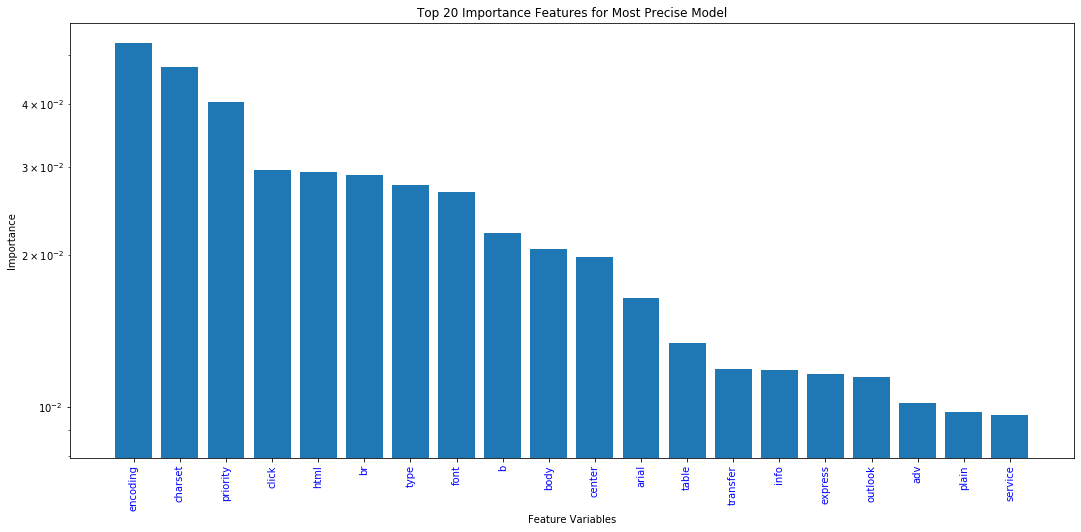

In [53]:
feature_importance = [i for i in zip(vectorizer.get_feature_names(), most_accurate_model.feature_importances_)]
feature_importance_20 = sorted(feature_importance, key = lambda x: x[1], reverse=True)[:20]
features = [f for (f, i) in feature_importance_20]
importance = [i for (f, i) in feature_importance_20]
plt.figure(figsize=(18, 8))
plt.yscale('log', nonposy='clip')
plt.bar(range(len(importance)), importance, align='center')
plt.xticks(range(len(importance)), features, rotation='vertical', color = 'blue')
plt.title('Top 20 Importance Features for Most Precise Model')
plt.ylabel('Importance')
plt.xlabel('Feature Variables')
plt.show()

## References

- http://www.cs.ucf.edu/courses/cap5636/fall2011/nltk.pdf
- https://bbengfort.github.io/tutorials/2016/05/19/text-classification-nltk-sckit-learn.html
- https://www.cs.bgu.ac.il/~elhadad/nlp16/spam_classifier.html
- https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
- https://datawhatnow.com/feature-importance/
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

## Youtube

In [ ]:

from IPython.display import YouTubeVideo
YouTubeVideo('6n50CxNnC1E')